# Import libraries

In [1]:
## remove this, this is for my personal pc setup
import sys; import os; sys.path.append(os.path.expanduser('~/DropBox/my/projects/T/'))

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas   as pd
import operator as op

import numpy             as np
import seaborn           as sns
from datetime import datetime

import pyscope
from pyscope import read_ss

from IPython.display import IFrame

from T import * # want T to be accessible


%load_ext autoreload
%autoreload

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from fbprophet import Prophet
# https://twitter.com/seanjtaylor/status/1123278380369973248

# Read in the data

Read the data in from the retail sales CSV file in the examples folder then set the index to the 'date' column. We are also parsing dates in the data file.

In [4]:
coin_df = pd.read_csv('../data/bitcoin_price.csv', index_col='Date', parse_dates=True)

In [5]:
coin_df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2018-02-20,11231.8,11958.5,11231.80,11403.7,"9,926,540,000","189,536,000,000"
2018-02-19,10552.6,11273.8,10513.20,11225.3,"7,652,090,000","178,055,000,000"
2018-02-18,11123.4,11349.8,10326.00,10551.8,"8,744,010,000","187,663,000,000"
2018-02-17,10207.5,11139.5,10149.40,11112.7,"8,660,880,000","172,191,000,000"
2018-02-16,10135.7,10324.1,9824.82,10233.9,"7,296,160,000","170,960,000,000"


# Prepare for Prophet

For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy (you'll see why later). The new dataframe will initially be created with an integer index so we can rename the columns

In [6]:
df = coin_df.reset_index()

In [7]:
df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-02-20,11231.8,11958.5,11231.80,11403.7,"9,926,540,000","189,536,000,000"
1,2018-02-19,10552.6,11273.8,10513.20,11225.3,"7,652,090,000","178,055,000,000"
2,2018-02-18,11123.4,11349.8,10326.00,10551.8,"8,744,010,000","187,663,000,000"
3,2018-02-17,10207.5,11139.5,10149.40,11112.7,"8,660,880,000","172,191,000,000"
4,2018-02-16,10135.7,10324.1,9824.82,10233.9,"7,296,160,000","170,960,000,000"


Let's rename the columns as required by fbprophet. Additioinally, fbprophet doesn't like the index to be a datetime...it wants to see 'ds' as a non-index column, so we won't set an index differnetly than the integer index.

In [8]:
df=df.rename(columns={'Date':'ds', 'Open':'y'})

In [9]:
df.head()

,ds,y,High,Low,Close,Volume,Market Cap
0,2018-02-20,11231.8,11958.5,11231.80,11403.7,"9,926,540,000","189,536,000,000"
1,2018-02-19,10552.6,11273.8,10513.20,11225.3,"7,652,090,000","178,055,000,000"
2,2018-02-18,11123.4,11349.8,10326.00,10551.8,"8,744,010,000","187,663,000,000"
3,2018-02-17,10207.5,11139.5,10149.40,11112.7,"8,660,880,000","172,191,000,000"
4,2018-02-16,10135.7,10324.1,9824.82,10233.9,"7,296,160,000","170,960,000,000"


Now's a good time to take a look at your data.  Plot the data using pandas' ```plot``` function

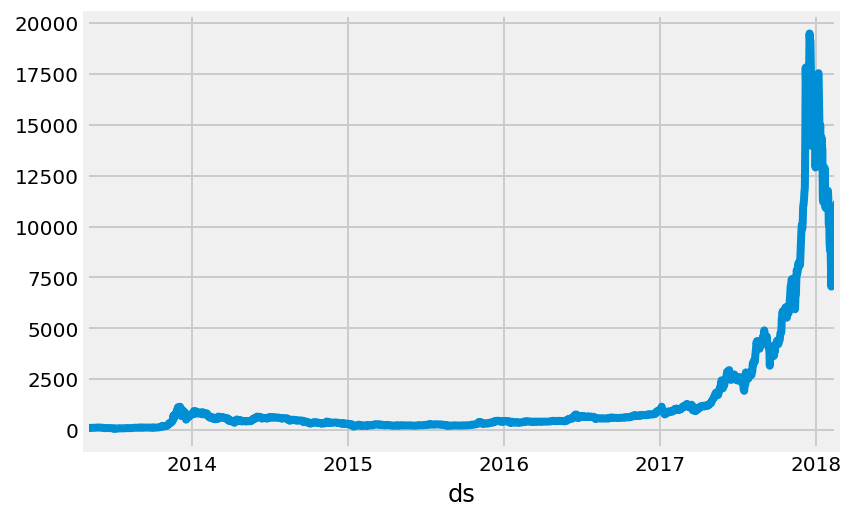

In [18]:
df.set_index('ds').y.plot()

# Running Prophet

Now, let's set prophet up to begin modeling our data.

Note: Since we are using daily data, you'll see a message from Prophet saying ```Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.```  This is OK since we are workign with daily data but you can disable it by using ```daily_seasonality=True``` in the instantiation of Prophet.

In [11]:
model = Prophet()
model.fit(df);

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Forecasting is fairly useless unless you can look into the future, so we need to add some future dates to our dataframe. For this example, I want to forecast 2 years into the future, so I'll built a future dataframe with 24 periods since we are working with monthly data. Note the ```freq='m'``` inclusion to ensure we are adding 24 months of data.

This can be done with the following code:


In [12]:
future = model.make_future_dataframe(periods=90, freq = 'd')
future.tail()

,ds
1845,2018-05-17
1846,2018-05-18
1847,2018-05-19
1848,2018-05-20
1849,2018-05-21


To forecast this future data, we need to run it through Prophet's model.

In [13]:
forecast = model.predict(future)

The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns.  First, let's look at the full dataframe:

In [14]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1845,2018-05-17,14650.197475,13338.707668,15800.438303,14464.132226,14848.535169,-170.401256,-170.401256,-170.401256,-1.205025,-1.205025,-1.205025,-169.196230,-169.196230,-169.196230,0.0,0.0,0.0,14479.796220
1846,2018-05-18,14684.142894,13211.875615,15833.744064,14494.172048,14886.476545,-169.177980,-169.177980,-169.177980,3.533660,3.533660,3.533660,-172.711641,-172.711641,-172.711641,0.0,0.0,0.0,14514.964913
1847,2018-05-19,14718.088312,13299.376035,15875.626971,14524.487801,14925.425684,-173.246495,-173.246495,-173.246495,3.112247,3.112247,3.112247,-176.358743,-176.358743,-176.358743,0.0,0.0,0.0,14544.841817
1848,2018-05-20,14752.033731,13314.679400,15941.136787,14554.251694,14964.013590,-167.476531,-167.476531,-167.476531,12.507840,12.507840,12.507840,-179.984371,-179.984371,-179.984371,0.0,0.0,0.0,14584.557199
1849,2018-05-21,14785.979149,13288.831168,15896.609131,14584.270930,15003.281699,-189.807205,-189.807205,-189.807205,-6.375769,-6.375769,-6.375769,-183.431436,-183.431436,-183.431436,0.0,0.0,0.0,14596.171944


We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:

In [15]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1845,2018-05-17,14479.796220,13338.707668,15800.438303
1846,2018-05-18,14514.964913,13211.875615,15833.744064
1847,2018-05-19,14544.841817,13299.376035,15875.626971
1848,2018-05-20,14584.557199,13314.679400,15941.136787
1849,2018-05-21,14596.171944,13288.831168,15896.609131


# Plotting Prophet results

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

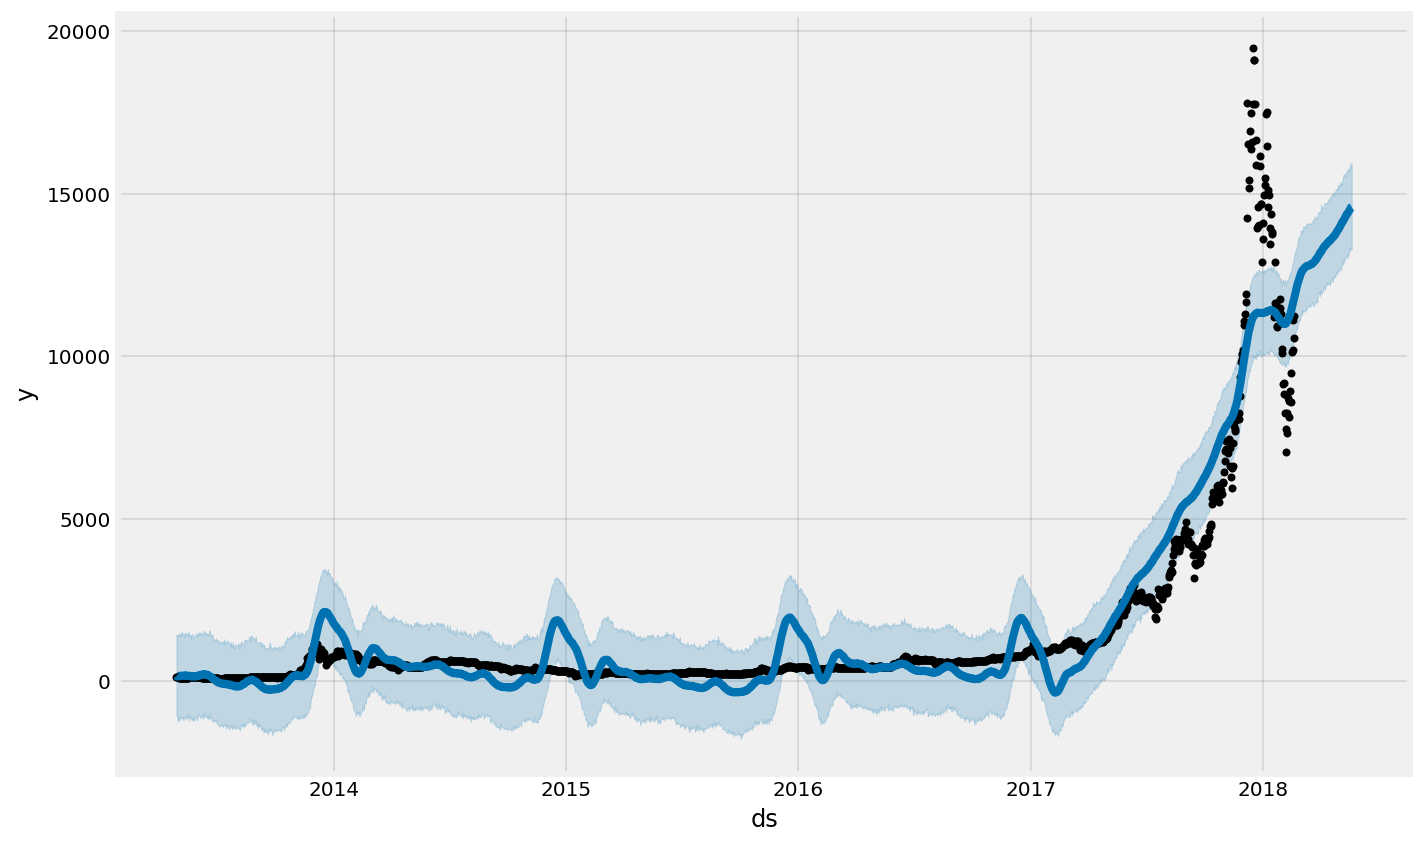

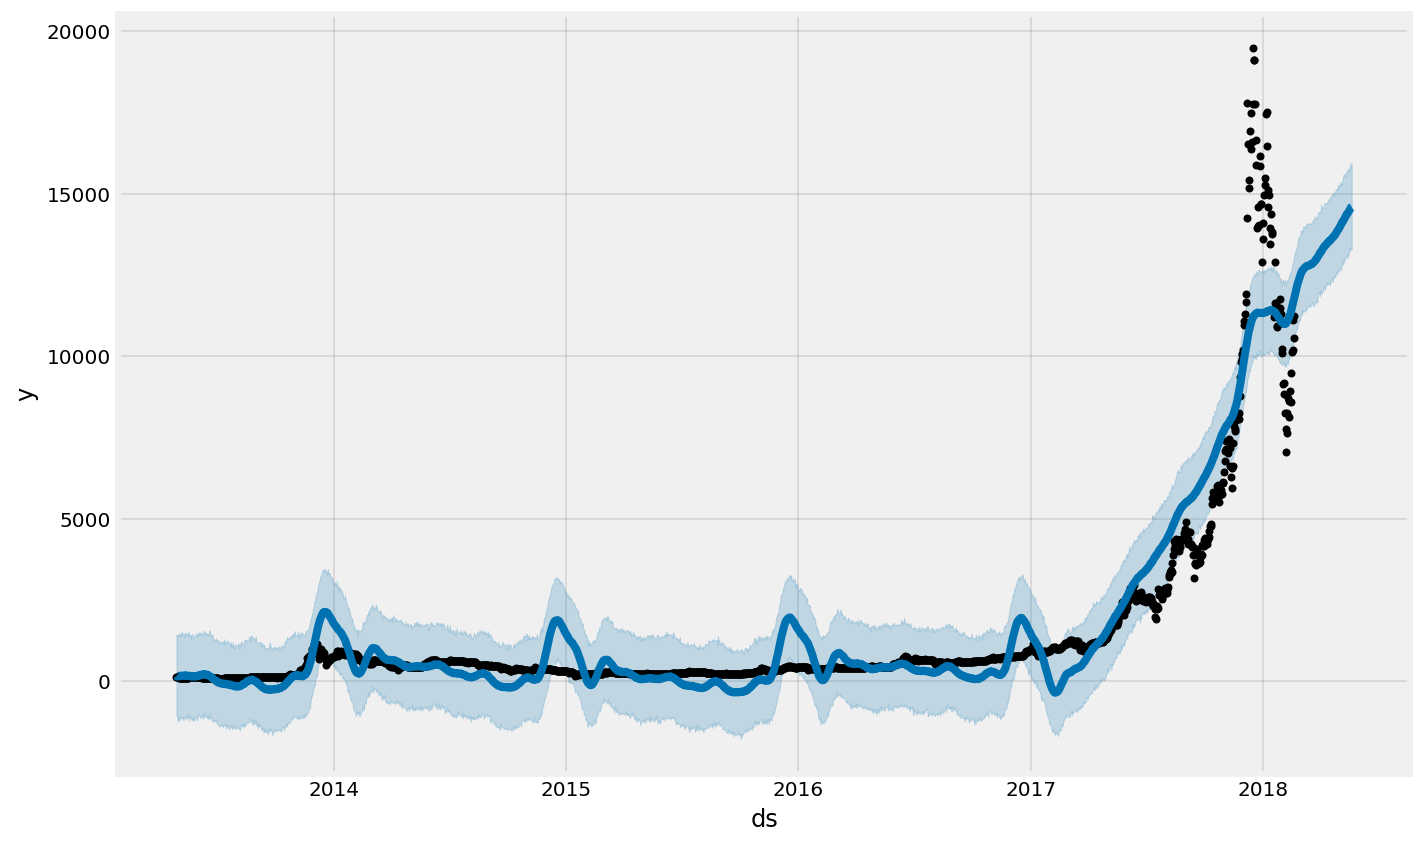

In [16]:
model.plot(forecast)

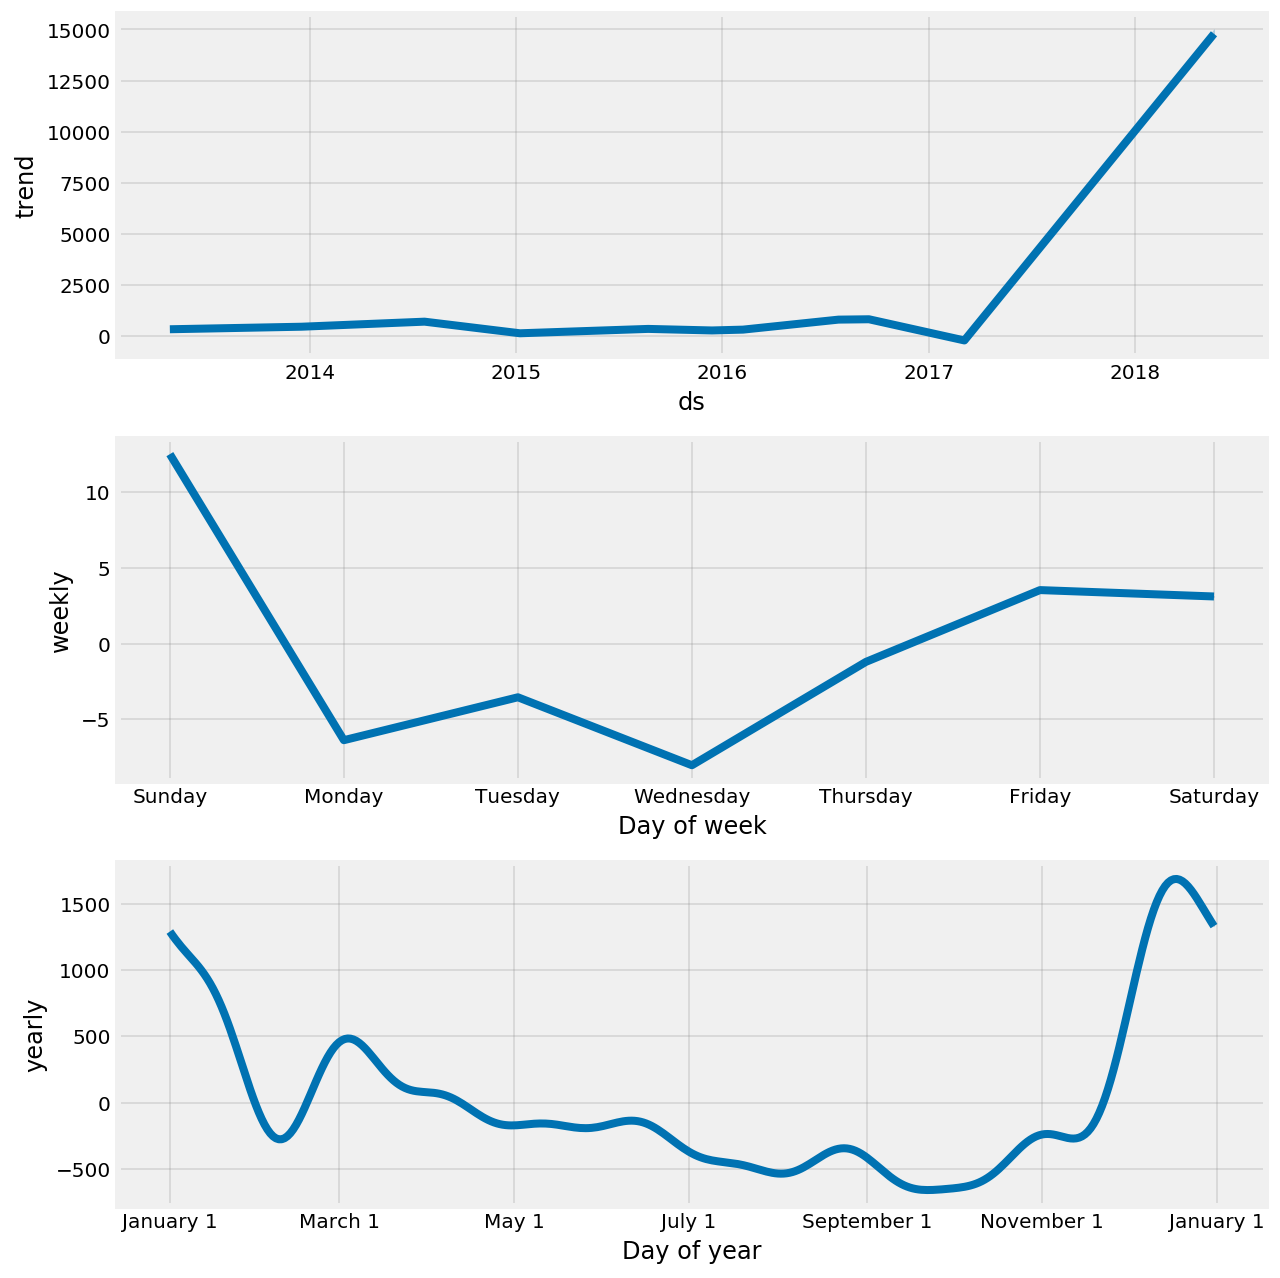

In [17]:
model.plot_components(forecast);